# 0. 思路说明

为简化计算, 先考虑一个公司一个股东的情况, 有两个需要模拟的方面:

模拟公司经营情况(财务数据, 被合规处罚情况, )

模拟股东状态和动作(增持减持, 股东身份, )





# 1. 部分工具

In [67]:
import platform
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def setup_chinese_font():
    """
    自动设置matplotlib的中文字体，根据操作系统类型选择合适的字体
    """
    system = platform.system()
    
    if system == 'Windows':
        # Windows系统默认安装的中文字体
        font_family = ['Microsoft YaHei', 'SimHei']
        
    elif system == 'Darwin':  # macOS
        # macOS系统默认安装的中文字体
        font_family = ['Arial Unicode MS', 'PingFang SC', 'Heiti SC']
        
    elif system == 'Linux':
        # Linux系统常见的中文字体
        font_family = ['WenQuanYi Micro Hei', 'Noto Sans CJK SC', 'SimHei']
    
    else:
        print(f"未知操作系统类型: {system}")
        return
    
    # 遍历字体列表，使用第一个可用的字体
    font_found = False
    for font in font_family:
        try:
            # 测试字体是否可用
            plt.rcParams['font.family'] = [font]
            plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
            
            # 创建一个测试图并立即关闭，验证字体是否有效
            fig = plt.figure()
            plt.text(0.5, 0.5, '测试中文字体')
            plt.close(fig)
            
            print(f"成功设置中文字体: {font}")
            font_found = True
            break
        except Exception as e:
            continue
    
    if not font_found:
        print(f"警告：在{system}系统上未找到可用的中文字体")
        print("请手动安装中文字体后重试")


# 使用示例
setup_chinese_font()

成功设置中文字体: Arial Unicode MS


## 1.1 可视化: 回购行为

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch # 需要导入 Patch
from matplotlib.lines import Line2D  # 需要导入 Line2D
from typing import Dict # 虽然函数内部没直接用，但保持风格一致
from datetime import timedelta # 同上

def plot_repurchase_and_selling_timeline(df: pd.DataFrame):
    """
    完全防御式的可视化函数，处理任何数据缺失情况。
    (已修正累计出售绘图错误)
    """
    # 检查基础列是否存在
    required_cols = ['日期', '收盘价']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("数据缺少必要列：日期和收盘价")

    # 确保日期列是 datetime 类型，以便绘图
    if not pd.api.types.is_datetime64_any_dtype(df['日期']):
        try:
            df['日期'] = pd.to_datetime(df['日期'])
        except Exception as e:
            raise ValueError(f"无法将 '日期' 列转换为 datetime 类型: {e}")

    # 确定可用的数据维度
    has_repurchase_cols = ['存在回购方案', '实施开始日', '实施截止日', '当日回购数量', '累计回购数量']
    has_selling_cols = ['存在出售计划', '出售开始日', '出售截止日', '当日出售数量', '累计出售数量']
    has_repurchase = all(col in df.columns for col in has_repurchase_cols)
    has_selling = all(col in df.columns for col in has_selling_cols)
    has_total_shares = '总股本' in df.columns


    # ======================
    # 配色方案配置
    # ======================
    color_config = {
        'repurchase': {
            'color': '#4B96E9',  # 商务蓝
            'alpha': 0.15,
            'bar_alpha': 0.7,
            'line_lw': 2
        },
        'selling': {
            'color': '#FF6B6B',  # 珊瑚红
            'alpha': 0.15,
            'bar_alpha': 0.7,
            'line_lw': 2
        },
        'price_line': '#2C3E50'  # 深灰色股价线
    }

    # 创建图表布局
    # 根据是否有交易量和累计比例数据调整子图数量和比例
    n_subplots = 1
    height_ratios = [1]
    if has_repurchase or has_selling:
        n_subplots += 1
        height_ratios = [2, 1] + height_ratios[1:] # 添加交易量图
    if (has_repurchase or has_selling) and has_total_shares:
        n_subplots += 1
        height_ratios = height_ratios[0:1] + [1] + height_ratios[1:] # 添加累计比例图

    fig = plt.figure(figsize=(14, n_subplots * 3)) # 动态调整高度
    gs = fig.add_gridspec(n_subplots, 1, height_ratios=height_ratios)

    ax_idx = 0
    ax1 = fig.add_subplot(gs[ax_idx])
    ax1.set_ylabel('股价 (元)', color=color_config['price_line'])
    ax1.tick_params(axis='y', labelcolor=color_config['price_line'])

    # ======================
    # 股价走势
    # ======================
    ax1.plot(df['日期'], df['收盘价'],
            label='收盘价',
            color=color_config['price_line'],
            lw=1.5,
            zorder=3) # 让股价线在最上层

    # ======================
    # 回购和出售期间标记 (在 ax1 上)
    # ======================
    legend_elements = [] # 用于统一图例

    if has_repurchase:
        # 使用 .loc 避免 SettingWithCopyWarning，并确保布尔索引正确
        repurchase_dates = df.loc[df['存在回购方案'] == True]
        if not repurchase_dates.empty:
            for _, row in repurchase_dates.iterrows():
                # 增加对 NaT 的检查
                start_date = pd.to_datetime(row.get('实施开始日'), errors='coerce')
                end_date = pd.to_datetime(row.get('实施截止日'), errors='coerce')
                if pd.notna(start_date) and pd.notna(end_date):
                    ax1.axvspan(
                        start_date,
                        end_date,
                        facecolor=color_config['repurchase']['color'],
                        alpha=color_config['repurchase']['alpha'],
                        zorder=1 # 在股价线下层
                    )
            # 添加图例元素 (Patch)
            legend_elements.append(Patch(facecolor=color_config['repurchase']['color'],
                                      alpha=color_config['repurchase']['alpha'] * 2, # 让图例块更明显
                                      label='回购期间'))

    if has_selling:
        selling_dates = df.loc[df['存在出售计划'] == True]
        if not selling_dates.empty:
            for _, row in selling_dates.iterrows():
                start_date = pd.to_datetime(row.get('出售开始日'), errors='coerce')
                end_date = pd.to_datetime(row.get('出售截止日'), errors='coerce')
                if pd.notna(start_date) and pd.notna(end_date):
                    ax1.axvspan(
                        start_date,
                        end_date,
                        facecolor=color_config['selling']['color'],
                        alpha=color_config['selling']['alpha'],
                        zorder=1
                    )
            legend_elements.append(Patch(facecolor=color_config['selling']['color'],
                                      alpha=color_config['selling']['alpha'] * 2,
                                      label='出售期间'))

    # 添加股价图例元素
    legend_elements.append(Line2D([0], [0], color=color_config['price_line'], lw=1.5, label='收盘价'))

    # ======================
    # 交易量图表（如果数据存在）
    # ======================
    if has_repurchase or has_selling:
        ax_idx += 1
        ax2 = fig.add_subplot(gs[ax_idx], sharex=ax1) # 共享 X 轴
        if has_repurchase:
            # 使用 .get 处理可能不存在的列，并确保数值类型
            rep_qty = pd.to_numeric(df.get('当日回购数量', 0), errors='coerce').fillna(0)
            ax2.bar(df['日期'], rep_qty / 10000, # 假设单位是股，转换为万股
                   width=1.0, # 根据日期密度调整
                   alpha=color_config['repurchase']['bar_alpha'],
                   color=color_config['repurchase']['color'],
                   label='当日回购 (万股)') # 添加具体标签
            legend_elements.append(Patch(facecolor=color_config['repurchase']['color'],
                                         alpha=color_config['repurchase']['bar_alpha'],
                                         label='当日回购量'))


        if has_selling:
            sell_qty = pd.to_numeric(df.get('当日出售数量', 0), errors='coerce').fillna(0)
            # 绘制负向柱状图表示出售
            ax2.bar(df['日期'], -sell_qty / 10000, # 假设单位是股，转换为万股，并取负
                   width=1.0,
                   alpha=color_config['selling']['bar_alpha'],
                   color=color_config['selling']['color'],
                   label='当日出售 (万股)') # 添加具体标签
            legend_elements.append(Patch(facecolor=color_config['selling']['color'],
                                         alpha=color_config['selling']['bar_alpha'],
                                         label='当日出售量'))

        ax2.axhline(0, color='gray', lw=0.5) # 添加 0 基准线
        ax2.set_ylabel('当日交易量 (万股)')
        plt.setp(ax1.get_xticklabels(), visible=False) # 隐藏上一个子图的 x 轴标签

    # ======================
    # 累计比例图表（如果数据存在）
    # ======================
    if (has_repurchase or has_selling) and has_total_shares:
        ax_idx += 1
        ax3 = fig.add_subplot(gs[ax_idx], sharex=ax1) # 共享 X 轴
        # 获取初始总股本，确保是数值
        initial_total_shares = pd.to_numeric(df['总股本'].iloc[0], errors='coerce')
        if pd.isna(initial_total_shares) or initial_total_shares == 0:
             print("警告：无法获取有效的初始总股本，累计比例图可能不准确。")
             initial_total_shares = 1 # 避免除零错误，但结果无意义

        if has_repurchase:
            # 获取累计回购列，确保是数值
            cum_rep_qty = pd.to_numeric(df.get('累计回购数量', 0), errors='coerce').fillna(0)
            cum_repurchase_ratio = cum_rep_qty / initial_total_shares
            ax3.plot(df['日期'], cum_repurchase_ratio,
                    color=color_config['repurchase']['color'],
                    lw=color_config['repurchase']['line_lw'],
                    label='累计回购比例') # 添加具体标签
            legend_elements.append(Line2D([0], [0], color=color_config['repurchase']['color'],
                                         lw=color_config['repurchase']['line_lw'], label='累计回购比例'))


        if has_selling:
            # --- 修正部分 ---
            # 直接使用累计出售列
            cum_sell_qty = pd.to_numeric(df.get('累计出售数量', 0), errors='coerce').fillna(0)
            cum_selling_ratio = cum_sell_qty / initial_total_shares
            # --- 修正结束 ---
            ax3.plot(df['日期'], cum_selling_ratio,
                    color=color_config['selling']['color'],
                    lw=color_config['selling']['line_lw'],
                    label='累计出售比例') # 添加具体标签
            legend_elements.append(Line2D([0], [0], color=color_config['selling']['color'],
                                         lw=color_config['selling']['line_lw'], label='累计出售比例'))

        ax3.set_ylabel('累计占初始股本比例')
        ax3.yaxis.set_major_formatter(plt.FuncFormatter('{:.1%}'.format)) # 格式化为百分比
        ax3.grid(axis='y', linestyle='--', alpha=0.5) # 添加水平网格线
        plt.setp(ax2.get_xticklabels(), visible=False) # 隐藏上一个子图的 x 轴标签 (如果ax2存在)

    # ======================
    # 图表装饰
    # ======================
    # 统一设置图例在第一个子图 (ax1) 上方
    # 去重图例元素 (基于标签)
    unique_legend_elements = {p.get_label(): p for p in legend_elements}.values()
    ax1.legend(handles=unique_legend_elements, loc='upper center',
               bbox_to_anchor=(0.5, 1.15), # 调整位置到标题下方
               ncol=min(len(unique_legend_elements), 4), # 根据数量调整列数
               fontsize='small')

    # 获取最后一个可见的 x 轴进行格式化
    last_ax = fig.axes[-1]
    last_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    last_ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10)) # 自动调整日期密度
    plt.setp(last_ax.get_xticklabels(), rotation=30, ha='right') # 旋转标签

    title = '股价走势'
    if has_repurchase and has_selling:
        title += '、回购与出售情况'
    elif has_repurchase:
        title += '与回购情况'
    elif has_selling:
        title += '与出售情况'

    fig.suptitle(title, fontsize=14, y=0.98) # 主标题
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 调整布局，给标题和图例留空间
    plt.show()



## 1.2 可视化: 财务和交易数据

In [69]:
import matplotlib.pyplot as plt

def draw_financial_and_treading(combined_company_info):

    combined_company_info = combined_company_info.copy()


    # 创建图表
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # 绘制上面的子图
    # 绘制收盘价和收盘价减每股净资产的折线图
    ax1.plot(combined_company_info['日期'], combined_company_info['收盘价'], label='收盘价', color='blue')
    ax1.plot(combined_company_info['日期'], combined_company_info['收盘价减每股净资产'], label='收盘价减每股净资产', color='green', alpha=0.3)

    # 创建右侧的坐标轴用于绘制日收益率
    ax1_2 = ax1.twinx()
    ax1_2.bar(combined_company_info['日期'], combined_company_info['日收益率'], color='gray', alpha=0.3, label='日收益率')
    ax1_2.set_ylabel('日收益率', color='gray')
    ax1_2.tick_params(axis='y', labelcolor='gray')

    # 在收益率的坐标轴上添加增长率为0的横线
    ax1_2.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    # 设置标签和图例
    ax1.set_ylabel('价格（元）')
    ax1.legend(loc='upper left')
    ax1_2.legend(loc='upper right')

    # 绘制下面的子图
    # 绘制净资产和净利润的折线图
    ax2.plot(combined_company_info['日期'], combined_company_info['净资产'], label='净资产', color='blue')
    ax2.plot(combined_company_info['日期'], combined_company_info['净利润'], label='净利润', color='green')

    # 创建右侧的坐标轴用于绘制净资产增长率和净利润增长率
    ax2_2 = ax2.twinx()
    width = 5  # 设置柱状图的宽度
    ax2_2.bar(combined_company_info['日期'], combined_company_info['净资产增长率'], width=width, alpha=0.1, color='blue', label='净资产增长率')
    ax2_2.bar(combined_company_info['日期'], combined_company_info['净利润增长率'], width=width, alpha=0.1, color='green', label='净利润增长率')
    ax2_2.set_ylabel('增长率', color='red')
    ax2_2.tick_params(axis='y', labelcolor='red')

    # 在增长率的坐标轴上添加增长率为0的横线
    ax2_2.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    # 设置标签和图例
    ax2.set_xlabel('日期')
    ax2.set_ylabel('值')
    ax2.legend(loc='upper left')
    ax2_2.legend(loc='upper right')

    # 添加网格和横线
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.axhline(0, color='gray', linewidth=0.8)
    ax2.axhline(0, color='gray', linewidth=0.8)

    # 设置标题
    ax1.set_title('收盘价、收盘价减每股净资产及日收益率')
    ax2.set_title('净资产、净利润及其增长率')

    # 显示图表
    plt.tight_layout()
    plt.show()
    

# 生成模拟数据

## 单个公司单个股东情况

### 财务数据

In [70]:
import pandas as pd
import numpy as np

DEFAULT_FINANCIAL_CONFIG = {
    # 时间范围配置
    "date_range": {
        "start_date": "2020-01-01",
        "end_date": "2024-12-31",
        "freq": "QE-DEC"  # 季度末日期
    },
    
    # 财务初始值配置
    "initial_values": {
        "net_assets": 180_000_000,    # 初始净资产
        "net_profit": 18_000_000,     # 初始净利润
        "total_shares": 40_000_000,   # 总股本
        "profit_adjustment": -17_000_000  # 净利润调整值
    },
    
    # 增长率配置
    "growth_rates": {
        "net_assets": {"mean": 0.03, "std": 0.09},
        "net_profit": {"mean": 0.05, "std": 0.4}
    },
    
    # 验证条件配置
    "validation": {
        "max_profit_asset_ratio": 0.3,          # 净利润/净资产最大比率
        "max_consecutive_loss_years": 3,        # 最大连续亏损年数
        "max_asset_growth_multiple": 5,         # 净资产最大增长倍数
        "min_loss_quarters": 2                  # 最小亏损季度数
    }
}

class FinancialDataGenerator:
    def __init__(self, config=None):
        self.config = config or DEFAULT_FINANCIAL_CONFIG
        self._process_config()
        
    def _process_config(self):
        """预处理配置参数"""
        # 生成季度日期序列
        date_cfg = self.config["date_range"]
        self.all_quarters = pd.date_range(
            start=date_cfg["start_date"],
            end=date_cfg["end_date"],
            freq=date_cfg["freq"]
        )
        self.num_quarters = len(self.all_quarters)
        
    def generate(self, max_retries=1000):
        """生成符合要求的财务数据"""
        for _ in range(max_retries):
            df = self._generate_base_data()
            df = self._calculate_derived_fields(df)
            if self._validate_data(df):
                return df
        raise ValueError("无法生成符合条件的数据，请调整配置参数")

    def _generate_base_data(self):
        """生成基础数据"""
        growth = self.config["growth_rates"]
        df = pd.DataFrame({
            "日期": self.all_quarters,
            "净资产增长率": np.random.normal(
                growth["net_assets"]["mean"],
                growth["net_assets"]["std"],
                self.num_quarters
            ),
            "净利润增长率": np.random.normal(
                growth["net_profit"]["mean"],
                growth["net_profit"]["std"],
                self.num_quarters
            )
        })
        return df

    def _calculate_derived_fields(self, df):
        """计算衍生字段"""
        init = self.config["initial_values"]
        
        # 计算累积增长率
        df["净资产"] = init["net_assets"] * (1 + df["净资产增长率"]).cumprod()
        df["净利润"] = init["net_profit"] * (1 + df["净利润增长率"]).cumprod()
        
        # 应用调整项
        df["净利润"] += init["profit_adjustment"]
        
        # 计算每股指标
        df["总股本"] = init["total_shares"]
        df["每股净资产"] = df["净资产"] / df["总股本"]
        df["每股净利润"] = df["净利润"] / df["总股本"]
        
        # 公告相关字段
        df["公告类型"] = df["日期"].apply(self._get_report_type)
        df["公告日期"] = df["日期"].apply(self._get_announcement_date)
        df["复权因子"] = 1
        
        return df

    def _get_report_type(self, date):
        """确定财务报告类型"""
        fmt_date = date.strftime("%m-%d")
        return {
            "03-31": "季报",
            "06-30": "半年报",
            "09-30": "季报",
            "12-31": "年报"
        }.get(fmt_date, None)

    def _get_announcement_date(self, date):
        """计算公告日期"""
        year = date.year
        month_day = date.strftime("%m-%d")
        
        if month_day == "06-30":
            return pd.Timestamp(f"{year}-08-27")  # 半年报的公告日期: 当年8月27日
        if month_day == "12-31":
            return pd.Timestamp(f"{year+1}-03-30") # 年报的公告日期: 次年3月30日
        if month_day == "03-31":
            return pd.Timestamp(f"{year}-04-30") # (一)季报的公告日期: 当年4月30日
        if month_day == "09-30":
            return pd.Timestamp(f"{year}-10-27") # (三)季报的公告日期: 当年10月27日
        return None

    def _validate_data(self, df):
        """验证数据是否符合业务规则"""
        val_cfg = self.config["validation"]
        
        # 条件1: 净利润/净资产比率限制
        ratio_condition = (df["净利润"] / df["净资产"] <= val_cfg["max_profit_asset_ratio"]).all()
        
        # 条件2: 连续亏损年数限制
        annual_profit = df.set_index("日期")["净利润"].resample("YE").sum()
        consecutive_loss = (annual_profit < 0).astype(int).groupby((annual_profit >= 0).cumsum()).cumsum()
        loss_condition = (consecutive_loss <= val_cfg["max_consecutive_loss_years"]).all()
        
        # 条件3: 净资产增长倍数限制
        asset_growth_condition = (df["净资产"].iloc[-1] / df["净资产"].iloc[0] <= val_cfg["max_asset_growth_multiple"])
        
        # 条件4: 最小亏损季度数
        loss_quarters_condition = (df["净利润"] < 0).sum() >= val_cfg["min_loss_quarters"]
        
        return all([ratio_condition, loss_condition, asset_growth_condition, loss_quarters_condition])


generator = FinancialDataGenerator()
# 生成数据
financial_data = generator.generate()

# 查看结果
financial_data

,日期,净资产增长率,净利润增长率,净资产,净利润,总股本,每股净资产,每股净利润,公告类型,公告日期,复权因子
0,2020-03-31,-0.000393,0.381638,1.799293e+08,7.869488e+06,40000000,4.498232,0.196737,季报,2020-04-30,1
1,2020-06-30,0.091146,-0.176923,1.963291e+08,3.469516e+06,40000000,4.908226,0.086738,半年报,2020-08-27,1
2,2020-09-30,0.330143,-0.100866,2.611458e+08,1.404841e+06,40000000,6.528644,0.035121,季报,2020-10-27,1
3,2020-12-31,-0.019768,-0.384149,2.559834e+08,-5.665360e+06,40000000,6.399584,-0.141634,年报,2021-03-30,1
4,2021-03-31,-0.017194,0.089780,2.515821e+08,-4.647734e+06,40000000,6.289552,-0.116193,季报,2021-04-30,1
5,2021-06-30,0.173446,-0.139387,2.952179e+08,-6.369481e+06,40000000,7.380446,-0.159237,半年报,2021-08-27,1
6,2021-09-30,-0.055914,0.104540,2.787109e+08,-5.258170e+06,40000000,6.967773,-0.131454,季报,2021-10-27,1
7,2021-12-31,0.106897,-0.299708,3.085044e+08,-8.777290e+06,40000000,7.712611,-0.219432,年报,2022-03-30,1
8,2022-03-31,-0.201483,0.214284,2.463462e+08,-7.015298e+06,40000000,6.158654,-0.175382,季报,2022-04-30,1
9,2022-06-30,-0.060728,0.072710,2.313861e+08,-6.289308e+06,40000000,5.784653,-0.157233,半年报,2022-08-27,1


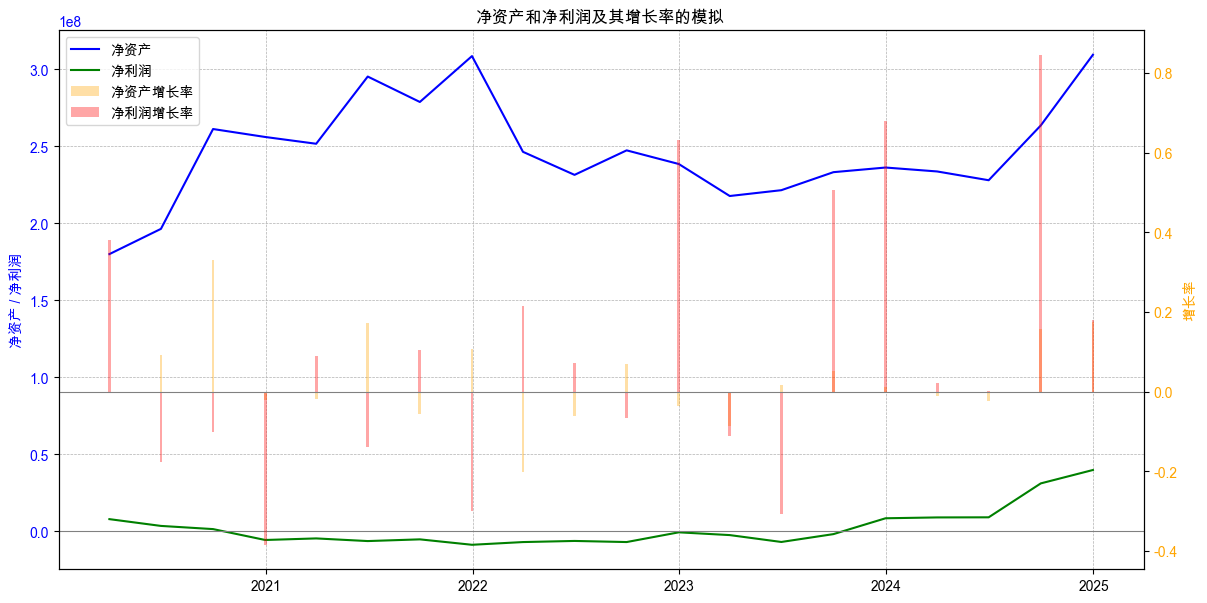

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.tseries.offsets import CustomBusinessDay


# 绘制图表
fig, ax1 = plt.subplots(figsize=(14, 7))

financial_df = financial_data

# 绘制净资产及净利润
ax2 = ax1.twinx()
ax1.plot(financial_df['日期'], financial_df['净资产'], color='blue', label='净资产')
ax1.plot(financial_df['日期'], financial_df['净利润'], color='green', label='净利润')
ax1.set_ylabel('净资产 / 净利润', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
lines_1, labels_1 = ax1.get_legend_handles_labels()  # 获取图例信息

# 绘制净资产增长率和净利润增长率的柱状图
width = 5  # 设置柱状图的宽度
ax2.bar(financial_df['日期'], financial_df['净资产增长率'], width=width, alpha=0.35, color='orange', label='净资产增长率')
ax2.bar(financial_df['日期'], financial_df['净利润增长率'], width=width, alpha=0.35, color='red', label='净利润增长率')
ax2.set_ylabel('增长率', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
lines_2, labels_2 = ax2.get_legend_handles_labels()  # 获取图例信息

# 合并和显示图例
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

# 加横线
ax1.axhline(0, color='gray', linewidth=0.8)
ax2.axhline(0, color='gray', linewidth=0.8)  # 在增长率为0的位置添加横线

# 标题和网格
plt.title('净资产和净利润及其增长率的模拟')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### 交易数据

In [72]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import CustomBusinessDay

DEFAULT_TRADING_CONFIG = {
    # 时间范围配置
    "date_range": {
        "start_date": "2020-01-01",
        "end_date": "2024-12-31"
    },
    
    # 市场参数配置
    "market_params": {
        "initial_price": 15.0,           # 初始股价
        "mean_return": 0.0002,           # 日均收益率
        "return_std": 0.02,              # 收益率标准差
        "trading_days_per_year": 242     # 年交易天数估算
    },
    
    # 假期配置（可根据实际情况调整）
    "holiday_rules": {
        "new_year_days": 1,              # 新年放假天数
        "spring_festival": {
            "start_month": 1, 
            "start_day": 24,
            "duration": 7
        },
        "qingming": {
            "start_month": 4,
            "start_day": 4,
            "duration": 3
        },
        "labor_day": {
            "start_month": 5,
            "start_day": 1,
            "duration": 5
        },
        "dragon_boat": {
            "start_month": 6,
            "start_day": 25,
            "duration": 3
        },
        "national_day": {
            "start_month": 10,
            "start_day": 1,
            "duration": 7
        }
    }
}

class TradingDataGenerator:
    def __init__(self, config=None):
        self.config = config or DEFAULT_TRADING_CONFIG
        self.trading_days = None
        self._prepare_calendar()
        
    def _prepare_calendar(self):
        """准备交易日历"""
        # 生成假期日期
        years = pd.date_range(
            start=self.config["date_range"]["start_date"],
            end=self.config["date_range"]["end_date"]
        ).year.unique()
        
        self.holidays = self._generate_holidays(years)
        
        # 创建交易日历
        trading_cal = CustomBusinessDay(holidays=self.holidays)
        self.trading_days = pd.date_range(
            start=self.config["date_range"]["start_date"],
            end=self.config["date_range"]["end_date"],
            freq=trading_cal
        )
    
    def _generate_holidays(self, years):
        """生成中国假期日期列表"""
        holidays = []
        for year in years:
            # 新年
            holidays.append(f"{year}-01-01")
            
            # 生成各假期
            h_rules = self.config["holiday_rules"]
            holidays += self._create_holiday_range(year, h_rules["spring_festival"])
            holidays += self._create_holiday_range(year, h_rules["qingming"])
            holidays += self._create_holiday_range(year, h_rules["labor_day"])
            holidays += self._create_holiday_range(year, h_rules["dragon_boat"])
            holidays += self._create_holiday_range(year, h_rules["national_day"])
        
        return pd.to_datetime(holidays).date.tolist()
    
    def _create_holiday_range(self, year, rule):
        """创建假期日期范围"""
        start_date = pd.Timestamp(year, rule["start_month"], rule["start_day"])
        return pd.date_range(
            start=start_date,
            periods=rule["duration"]
        ).strftime("%Y-%m-%d").tolist()
    
    def generate(self):
        """生成完整的交易数据"""
        params = self.config["market_params"]
        
        # 生成收益率序列
        returns = np.random.normal(
            params["mean_return"],
            params["return_std"],
            len(self.trading_days)
        )
        
        # 计算价格序列
        prices = params["initial_price"] * (1 + returns).cumprod()
        
        # 构建DataFrame
        df = pd.DataFrame({
            "日期": self.trading_days,
            "日收益率": returns,
            "收盘价": prices
        })
        
        # 添加前收盘价
        df["前收盘价"] = df["收盘价"].shift(1)

        # 添加上市日期
        # 过滤出在2021-01-01到2022-09-01之间的日期
        filtered_dates = df[(df['日期'] >= '2021-01-03') & (df['日期'] <= '2021-09-01')]['日期']
        # 从过滤后的日期中随机选择一个日期
        listing_date = filtered_dates.sample(n=1).iloc[0]
        df['上市日期'] = listing_date

        # 假设发行价格等于发行当日的收盘价
        df['发行价格'] = df.loc[df['日期'] == listing_date, '收盘价'].values[0]   
        
        # 将上市日期之前的数据替换为NaN
        df.loc[df['日期'] < listing_date, ['日收益率', '收盘价', '前收盘价', '发行价格']] = np.nan

        
        df['总股本'] = 40_000_000  # 假设总股本为4000万股
        df['复权因子'] = 1
        
        # 清理首行空值
        return df

    def plot_price_series(self, df):
        """绘制价格序列（可选方法）"""
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        plt.plot(df["日期"], df["收盘价"])
        plt.title("股票价格走势")
        plt.xlabel("日期")
        plt.ylabel("收盘价")
        plt.grid(True)
        plt.show()

trading_gen = TradingDataGenerator()
trading_df = trading_gen.generate()

trading_df

,日期,日收益率,收盘价,前收盘价,上市日期,发行价格,总股本,复权因子
0,2020-01-02,NaN,NaN,NaN,2021-02-22,NaN,40000000,1
1,2020-01-03,NaN,NaN,NaN,2021-02-22,NaN,40000000,1
2,2020-01-06,NaN,NaN,NaN,2021-02-22,NaN,40000000,1
3,2020-01-07,NaN,NaN,NaN,2021-02-22,NaN,40000000,1
4,2020-01-08,NaN,NaN,NaN,2021-02-22,NaN,40000000,1
...,...,...,...,...,...,...,...,...
1209,2024-12-25,0.015116,30.537969,30.083231,2021-02-22,14.496751,40000000,1
1210,2024-12-26,-0.021223,29.889851,30.537969,2021-02-22,14.496751,40000000,1
1211,2024-12-27,0.008818,30.153413,29.889851,2021-02-22,14.496751,40000000,1
1212,2024-12-30,-0.024600,29.411627,30.153413,2021-02-22,14.496751,40000000,1


In [73]:
trading_df.columns

Index(['日期', '日收益率', '收盘价', '前收盘价', '上市日期', '发行价格', '总股本', '复权因子'], dtype='object')

### 整合数据

In [74]:
import pandas as pd
import numpy as np

def merge_financial_trade_data(financial_df, tread_df):
    """
    合并财务数据和交易数据
    """
    # 转换日期列为 datetime 类型，并去除时区信息和时间部分
    financial_df['日期'] = pd.to_datetime(financial_df['日期']).dt.date
    financial_df['公告日期'] = pd.to_datetime(financial_df['公告日期']).dt.date
    tread_df['日期'] = pd.to_datetime(tread_df['日期']).dt.date

    # 读取 tread_df 的第一日和最后一日
    start_date = tread_df['日期'].min()
    end_date = tread_df['日期'].max()

    # 创建包含全部日期的序列
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date
    combined_company_info = pd.DataFrame({'日期': all_dates})

    # 将 tread_df 的数据按照日期填入
    combined_company_info = combined_company_info.merge(tread_df, on='日期', how='left')

    # 遍历 combined_company_info，根据 '日期' 去匹配 financial_df
    for idx, row in combined_company_info.iterrows():
        current_date = row['日期']

        # 找到 financial_df 中 '公告日期' 早于当前日期的最晚的一行
        matching_rows = financial_df[financial_df['公告日期'] <= current_date]

        if not matching_rows.empty:
            latest_row = matching_rows.loc[matching_rows['公告日期'].idxmax()]

            # 删除 latest_row 中的 '日期' 列
            latest_row = latest_row.drop('日期')

            # 将这一行数据拼接到 combined_company_info
            for col in latest_row.index:
                if col not in combined_company_info.columns:
                    if '公告类型' in col:
                        combined_company_info[col] = ''
                    elif '日期' in col:
                        combined_company_info[col] = '' # pd.NaT
                    else:
                        combined_company_info[col] = np.nan  # 添加新列并初始化为 NaN
                combined_company_info.at[idx, col] = latest_row[col]

    # 将 <NA> 替换为 NaN
    combined_company_info = combined_company_info.replace({pd.NA: np.nan})

    # 筛选出交易日，并删除非交易日的行
    trade_dates = tread_df['日期']
    combined_company_info = combined_company_info[combined_company_info['日期'].isin(trade_dates)]

    # 计算每股净资产、每股净利润及其他列
    combined_company_info['每股净资产'] = combined_company_info['净资产'] / combined_company_info['总股本']
    combined_company_info['每股净利润'] = combined_company_info['净利润'] / combined_company_info['总股本']
    combined_company_info['收盘价减每股净资产'] = combined_company_info['收盘价'] - combined_company_info['每股净资产']
    combined_company_info['收盘价减每股净利润'] = combined_company_info['收盘价'] - combined_company_info['每股净利润']

    return combined_company_info



combined_company_info = merge_financial_trade_data(financial_data, trading_df)
combined_company_info = combined_company_info.dropna(subset=['净资产'])
combined_company_info

,日期,日收益率,收盘价,前收盘价,上市日期,发行价格,总股本,复权因子,净资产增长率,净利润增长率,净资产,净利润,每股净资产,每股净利润,公告类型,公告日期,收盘价减每股净资产,收盘价减每股净利润
119,2020-04-30,NaN,NaN,NaN,2021-02-22,NaN,40000000.0,1.0,-0.000393,0.381638,1.799293e+08,7.869488e+06,4.498232,0.196737,季报,2020-04-30,NaN,NaN
125,2020-05-06,NaN,NaN,NaN,2021-02-22,NaN,40000000.0,1.0,-0.000393,0.381638,1.799293e+08,7.869488e+06,4.498232,0.196737,季报,2020-04-30,NaN,NaN
126,2020-05-07,NaN,NaN,NaN,2021-02-22,NaN,40000000.0,1.0,-0.000393,0.381638,1.799293e+08,7.869488e+06,4.498232,0.196737,季报,2020-04-30,NaN,NaN
127,2020-05-08,NaN,NaN,NaN,2021-02-22,NaN,40000000.0,1.0,-0.000393,0.381638,1.799293e+08,7.869488e+06,4.498232,0.196737,季报,2020-04-30,NaN,NaN
130,2020-05-11,NaN,NaN,NaN,2021-02-22,NaN,40000000.0,1.0,-0.000393,0.381638,1.799293e+08,7.869488e+06,4.498232,0.196737,季报,2020-04-30,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,2024-12-25,0.015116,30.537969,30.083231,2021-02-22,14.496751,40000000.0,1.0,0.156154,0.845502,2.634878e+08,3.108090e+07,6.587196,0.777022,季报,2024-10-27,23.950773,29.760947
1820,2024-12-26,-0.021223,29.889851,30.537969,2021-02-22,14.496751,40000000.0,1.0,0.156154,0.845502,2.634878e+08,3.108090e+07,6.587196,0.777022,季报,2024-10-27,23.302655,29.112828
1821,2024-12-27,0.008818,30.153413,29.889851,2021-02-22,14.496751,40000000.0,1.0,0.156154,0.845502,2.634878e+08,3.108090e+07,6.587196,0.777022,季报,2024-10-27,23.566217,29.376391
1824,2024-12-30,-0.024600,29.411627,30.153413,2021-02-22,14.496751,40000000.0,1.0,0.156154,0.845502,2.634878e+08,3.108090e+07,6.587196,0.777022,季报,2024-10-27,22.824431,28.634604


### 回购行为

In [75]:
import pandas as pd
import numpy as np
from typing import Dict

# ========================
# 新增配置参数
# ========================
REPO_CONFIG = {
    # 方案生成
    'prob_initiate_repurchase': 0.03,  # 无方案时每日发起概率
    'min_repurchase_days': 10,        # 最小回购实施天数
    'max_repurchase_days': 180,       # 最大回购实施天数
    
    # 方案特征概率
    'method_prob': [0.7, 0.3],       # 回购方式概率 [竞价, 要约]
    'purpose_prob': [0.5, 0.3, 0.2], # 用途概率 [维护价值, 股权激励, 转债]
    
    # 信息披露概率（每个要素独立概率）
    'disclosure_prob': 0.6,           # 各要素披露概率
    
    # 要约特征
    'offer_period_range': (30, 60),   # 要约期限天数范围
    'offer_price_lookback': 30,       # 要约价格参考前N日
    
    # 执行参数
    'prob_daily_execute': 0.4,        # 符合条件时每日执行概率
    'max_daily_ratio': 0.05,          # 单日最大回购比例（总股本）

    # 违法行为概率
    'prob_legal_violation': 0.005,  # 每日发生重大违法行为的概率
}

# ========================
# 工具函数
# ========================
def is_valid_trading_day(date: pd.Timestamp, df: pd.DataFrame) -> bool:
    """检查日期是否为交易日"""
    return date in df['日期'].values

def generate_offer_price(current_date: pd.Timestamp, df: pd.DataFrame, lookback: int) -> float:
    """生成要约价格（参考前lookback日的收盘价）"""
    try:
        # 获取当前日期的索引
        current_idx = df[df['日期'] == current_date].index[0]
        start_idx = max(0, current_idx - lookback)  # 确保不超出范围
        
        # 获取历史价格并过滤掉无效值
        historical_prices = df.iloc[start_idx:current_idx]['收盘价'].dropna()
        
        # 如果没有有效历史价格，则使用当前收盘价
        if len(historical_prices) == 0:
            return df.iloc[current_idx]['收盘价']
            
        return np.random.choice(historical_prices)
    except (IndexError, KeyError):
        # 如果出现任何错误，返回最近的有效收盘价
        valid_prices = df['收盘价'].dropna()
        if len(valid_prices) > 0:
            return valid_prices.iloc[-1]
        return 10.0  # 默认值，如果所有方法都失败

# ========================
# 核心处理函数
# ========================

def generate_repurchase_plan(prev_row: pd.Series, current_date: pd.Timestamp, df: pd.DataFrame) -> Dict:
    """
    生成回购计划（增强异常处理）
    返回包含计划要素的字典
    """
    try:
        # 新增收盘价非空检查
        current_close = df.loc[df['日期'] == current_date, '收盘价'].iloc[0]
        if pd.isna(current_close):
            return {}
    except IndexError:
        return {}

    # 原生成条件判断
    if prev_row['存在回购方案'] or np.random.rand() >= REPO_CONFIG['prob_initiate_repurchase']:
        return {}
    
    # 基础方案要素
    updates = {
        '存在回购方案': True,
        '决议通过日': current_date,
        '回购方式': np.random.choice(['竞价回购', '要约回购'], p=REPO_CONFIG['method_prob']),
        '回购用途': np.random.choice(['维护公司价值及股东权益所必需', 
                                  '股权激励或者员工持股计划', 
                                  '转换上市公司发行的可转换为股票的公司债券'], p=REPO_CONFIG['purpose_prob']),
    }
    
    # 随机生成披露要素
    if np.random.rand() < REPO_CONFIG['disclosure_prob']:
        updates['回购数量上限'] = np.random.randint(1, 5) * 0.01  # 总股本比例
    if np.random.rand() < REPO_CONFIG['disclosure_prob']:
        updates['回购数量下限'] = updates.get('回购数量上限', 0) * np.random.uniform(0.3, 0.7)
    if np.random.rand() < REPO_CONFIG['disclosure_prob']:
        updates['资金总额上限'] = prev_row['总股本'] * prev_row['收盘价'] * np.random.uniform(0.02, 0.1)
    if np.random.rand() < REPO_CONFIG['disclosure_prob']:
        updates['资金总额下限'] = updates.get('资金总额上限', 0) * np.random.uniform(0.3, 0.7)
    
    # 要约特殊处理（增强异常处理）
    if updates['回购方式'] == '要约回购':
        try:
            updates['要约期限'] = np.random.randint(*REPO_CONFIG['offer_period_range'])
            updates['要约价格'] = generate_offer_price(current_date, df, REPO_CONFIG['offer_price_lookback'])
        except:
            # 如果生成要约价格失败，改为竞价回购
            updates['回购方式'] = '竞价回购'
            updates.pop('要约期限', None)
            updates.pop('要约价格', None)
    
    # 计算实施期间
    start_date = current_date + pd.Timedelta(days=10)  # 假设决议后10日实施
    end_date = start_date + pd.Timedelta(
        days=np.random.randint(REPO_CONFIG['min_repurchase_days'], REPO_CONFIG['max_repurchase_days']))
    
    # 确保日期有效
    if is_valid_trading_day(start_date, df) and is_valid_trading_day(end_date, df):
        updates.update({
            '实施开始日': start_date,
            '实施截止日': end_date,
            '累计回购数量': 0,
            '已使用资金': 0.0
        })
        return updates
    return {}  # 日期无效时不生成

def execute_repurchase(prev_row: pd.Series, current_row: Dict, df: pd.DataFrame) -> Dict:
    """
    执行回购操作
    """
    if not prev_row['存在回购方案']:
        return current_row

    try:
        # 添加有效性检查
        if pd.isna(prev_row['收盘价']) or prev_row['收盘价'] <= 0:
            return current_row

        # 检查实施期间
        if not (prev_row['实施开始日'] <= current_row['日期'] <= prev_row['实施截止日']):
            return current_row

        # 价格生成（增强边界处理）
        if prev_row['回购方式'] == '竞价回购':
            base_price = prev_row['收盘价']
            lower = max(base_price * 0.8, 0.01)  # 防止出现0或负价格
            upper = base_price * 1.2
            price_range = (min(lower, upper), max(lower, upper))  # 确保范围有效
            current_row['申报价格'] = np.random.uniform(*price_range)
        else:
            # 要约价格生成增加边界保护
            try:
                current_row['申报价格'] = generate_offer_price(
                    current_row['日期'], 
                    df, 
                    REPO_CONFIG['offer_price_lookback']
                )
            except IndexError:
                current_row['申报价格'] = prev_row['收盘价']

        # 执行判断（增加资金上限检查）
        if (np.random.rand() < REPO_CONFIG['prob_daily_execute']) and pd.notna(prev_row.get('资金总额上限')):

            # 计算最大可回购量
            max_by_ratio = REPO_CONFIG['max_daily_ratio'] * prev_row['总股本']
            max_by_fund = (prev_row['资金总额上限'] - prev_row['已使用资金']) / current_row['申报价格']
            max_shares = min(max_by_ratio, max_by_fund)
            
            if max_shares > 0:
                execute_ratio = np.random.uniform(0.1, 0.5) * max_shares
                current_row['当日回购数量'] = execute_ratio
                current_row['累计回购数量'] = prev_row['累计回购数量'] + execute_ratio
                current_row['已使用资金'] = prev_row['已使用资金'] + execute_ratio * current_row['申报价格']
    
    except Exception as e:
        print(f"执行回购时出错 @ {current_row['日期']}: {str(e)}")
    
    return current_row

def check_and_reset_repurchase_plan(prev_row: pd.Series, current_row: Dict) -> Dict:
    """
    检查并重置已完成的回购计划
    """
    if not prev_row['存在回购方案']:
        return current_row
    
    # 检查是否超过截止日
    if current_row['日期'] > prev_row['实施截止日']:
        # 重置所有回购相关字段
        current_row.update({
            '存在回购方案': False,
            '决议通过日': pd.NaT,
            '实施开始日': pd.NaT,
            '实施截止日': pd.NaT,
            '回购方式': pd.NA,
            '回购用途': pd.NA,
            '回购数量上限': np.nan,
            '回购数量下限': np.nan,
            '资金总额上限': np.nan,
            '资金总额下限': np.nan,
            '要约期限': np.nan,
            '要约价格': np.nan,
            '申报价格': np.nan,
            '当日回购数量': 0.0,
            '累计回购数量': 0.0,
            '已使用资金': 0.0
        })
    
    return current_row

# ========================
# 主处理流程增强
# ========================
def main_simulation_repurchase(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 初始化回购相关列
    repo_columns = {
        '公司法律情况':'',
        '存在回购方案': False,
        '决议通过日': pd.NaT,
        '实施开始日': pd.NaT,
        '实施截止日': pd.NaT,
        '回购方式': pd.NA,
        '回购用途': pd.NA,
        '回购数量上限': np.nan,
        '回购数量下限': np.nan,
        '资金总额上限': np.nan,
        '资金总额下限': np.nan,
        '要约期限': np.nan,
        '要约价格': np.nan,
        '申报价格': np.nan,
        '当日回购数量': 0.0,
        '累计回购数量': 0.0,
        '已使用资金': 0.0
    }
    for col, default in repo_columns.items():
        df[col] = default
    
    for i in range(1, len(df)):
        prev = df.iloc[i-1]
        current_row = df.iloc[i].copy()
        current_date = current_row['日期']
        
        # 继承方案状态
        current_row.update({k: prev[k] for k in repo_columns.keys()})

        # 检查并处理违法行为（新增）
        if np.random.rand() < REPO_CONFIG['prob_legal_violation']:
            current_row['公司法律情况'] = '发生重大违法行为'
        
        # 检查并重置已完成的回购计划
        current_row = check_and_reset_repurchase_plan(prev, current_row)
        
        # 生成新方案（仅在无方案时）
        if not current_row['存在回购方案']:
            plan_updates = generate_repurchase_plan(prev, current_date, df)
            current_row.update(plan_updates)
        
        # 执行回购
        current_row = execute_repurchase(prev, current_row, df)
        
        # 更新总股本（示例逻辑）
        current_row['总股本'] = prev['总股本'] - current_row['当日回购数量']
        
        df.iloc[i] = current_row
    
    # 修正列顺序处理
    base_columns = [
        '日期', '收盘价', '总股本', '公司法律情况',
        '存在回购方案', '决议通过日', '实施开始日', '实施截止日',
        '回购方式', '回购用途', '回购数量上限', '回购数量下限',
        '资金总额上限', '资金总额下限', '要约期限', '要约价格',
        '申报价格', '当日回购数量', '累计回购数量', '已使用资金'
    ]
    
    # 获取其他列并去重
    other_columns = [col for col in df.columns if col not in base_columns]
    
    # 合并列顺序
    ordered_columns = base_columns + other_columns
    
    return df[ordered_columns]

In [76]:
generator = FinancialDataGenerator()
financial_data = generator.generate()

trading_gen = TradingDataGenerator()
trading_df = trading_gen.generate()

combined_company_info = merge_financial_trade_data(financial_data, trading_df)

combined_company_info_copy = combined_company_info.copy()
combined_company_info_copy['日期'] = pd.to_datetime(combined_company_info_copy['日期'])
# 运行模拟
one_company_df = main_simulation_repurchase(combined_company_info_copy)

# draw_financial_and_treading(combined_company_info)
# # plot_timeline(one_company_df)

### 出售回购股份行为

In [77]:
import pandas as pd
import numpy as np
from typing import Dict
from datetime import timedelta

# ========================
# 配置参数
# ========================
CONFIG = {
    # 出售计划相关参数
    'prob_daily_sell': 0.5,          # 每日执行出售的概率
    'min_planned_sell_ratio': 0.10,  # 拟出售比例下限（相对于累计回购比例）
    'max_planned_sell_ratio': 1.50,  # 拟出售比例上限（相对于累计回购比例）
    'max_daily_sell_ratio': 0.5,    # 每日最大出售比例（相对于拟出售数量）
    'prob_disclosure': 0.6,          # 披露出售进展的概率
    'min_sell_period': 10,           # 出售计划最小持续时间（天）
    'max_sell_period': 90,           # 出售计划最大持续时间（天）
    
    # 计算容差参数
    'float_tolerance': 1e-9,         # 浮点数比较容差
    
    # 价格波动范围
    'price_lower_bound_ratio': 0.9,  # 出售价格下限（相对于收盘价）
    'price_upper_bound_ratio': 1.1,  # 出售价格上限（相对于收盘价）
    
    # 安全参数
    'min_price': 0.01                # 出售价格绝对下限
}

def generate_sell_plan(prev_row: pd.Series, current_row: Dict, df: pd.DataFrame) -> Dict:
    """
    生成股票出售计划
    
    当满足以下条件时生成新计划：
    1. 前一日有剩余可出售股份（累计回购 > 累计出售）
    2. 回购已结束或回购无明确截止日
    3. 前一日不存在有效出售计划
    
    参数：
        prev_row: 前一日数据
        current_row: 当前日数据（将被修改）
        df: 完整数据表格（用于参考）
        
    返回：
        更新后的current_row
    """
    available_shares = prev_row['累计回购数量'] - prev_row['累计出售数量']
    shares_available = available_shares > CONFIG['float_tolerance']
    
    repurchase_ended = pd.isna(prev_row['实施截止日']) or current_row['日期'] > prev_row['实施截止日']
    
    if shares_available and repurchase_ended and not prev_row['存在出售计划']:
        sell_period = np.random.randint(
            CONFIG['min_sell_period'],
            CONFIG['max_sell_period'] + 1
        )
        
        # 计算累计回购比例（累计回购数量/总股本）
        repurchase_ratio = prev_row['累计回购数量'] / prev_row['总股本'] if prev_row['总股本'] > 0 else 0
        
        # 生成拟出售比例（累计回购比例的10%-150%）
        planned_ratio = np.random.uniform(
            CONFIG['min_planned_sell_ratio'],
            CONFIG['max_planned_sell_ratio']
        ) * repurchase_ratio
        
        current_row.update({
            '出售开始日': current_row['日期'],
            '出售截止日': current_row['日期'] + timedelta(days=sell_period),
            '拟出售比例': round(planned_ratio, 4),
            '拟出售数量': round(planned_ratio * prev_row['总股本'], 2),
            '存在出售计划': True,
            '累计出售数量': 0.0,  # 新计划重置累计值
            '累计出售比例': 0.0,   # 新计划重置
            # '计划内累计出售比例': 0.0  # 新计划重置
        })

    return current_row

def execute_sell_plan(prev_row: pd.Series, current_row: Dict, df: pd.DataFrame) -> Dict:
    """
    执行当日出售操作
    
    执行条件：
    1. 存在有效出售计划
    2. 当前日期在计划有效期内
    3. 仍有可出售股份
    4. 随机命中出售概率
    
    参数：
        prev_row: 前一日数据
        current_row: 当前日数据（将被修改）
        df: 完整数据表格
        
    返回：
        更新后的current_row
    """
    # 初始化默认值
    current_row.update({
        '当日出售价格': 0.0,
        '当日出售比例': 0.0,
        '当日出售数量': 0.0,
        '累计出售数量': prev_row['累计出售数量'],
        '累计出售比例': prev_row['累计出售比例'],
        # '计划内累计出售比例': prev_row['计划内累计出售比例'],
        '披露出售进展': False
    })

    if not current_row['存在出售计划']:
        return current_row

    # 检查计划有效期
    in_period = (pd.notna(current_row['出售开始日']) and 
                pd.notna(current_row['出售截止日']) and
                current_row['出售开始日'] <= current_row['日期'] <= current_row['出售截止日'])
    
    if not in_period:
        current_row['存在出售计划'] = False
        current_row['累计出售数量'] = 0
        return current_row

    try:
        remaining = max(0.0, prev_row['累计回购数量'] - prev_row['累计出售数量'])
        planned_remaining = max(0.0, current_row['拟出售数量'] - prev_row['累计出售数量'])
        
        if remaining > CONFIG['float_tolerance'] and planned_remaining > CONFIG['float_tolerance'] and np.random.rand() < CONFIG['prob_daily_sell']:
            close_price = current_row['收盘价']
            total_shares = current_row['总股本']
            
            if total_shares <= 0:
                return current_row

            # 生成出售价格
            sell_price = np.random.uniform(
                max(CONFIG['min_price'], close_price * CONFIG['price_lower_bound_ratio']),
                close_price * CONFIG['price_upper_bound_ratio']
            )

            # 计算最大可出售数量（考虑每日上限、拟出售剩余量和实际剩余量）
            daily_max = CONFIG['max_daily_sell_ratio'] * current_row['拟出售数量']
            max_sell = min(daily_max, planned_remaining, remaining)
            
            # 使用截断正态分布生成出售量（均值在最大值的1/3处）
            mean = max_sell / 3
            std = max_sell / 3
            sell_qty = np.random.normal(mean, std)
            
            # 确保出售量在合理范围内
            sell_qty = max(0.0, min(max_sell, sell_qty))
            
            # 计算各种比例
            sell_ratio = sell_qty / total_shares if total_shares > 0 else 0.0
            cumulative_ratio = (prev_row['累计出售数量'] + sell_qty) / prev_row['累计回购数量'] if prev_row['累计回购数量'] > 0 else 0.0
            plan_cumulative_ratio = (prev_row['累计出售数量'] + sell_qty) / current_row['拟出售数量'] if current_row['拟出售数量'] > 0 else 0.0
            
            # 更新数据
            current_row.update({
                '当日出售数量': sell_qty,
                '当日出售价格': round(sell_price, 2),
                '当日出售比例': round(sell_ratio, 6),
                '累计出售数量': prev_row['累计出售数量'] + sell_qty,
                '累计出售比例': round(cumulative_ratio, 4),
                # '计划内累计出售比例': round(plan_cumulative_ratio, 4),
                '披露出售进展': np.random.rand() < CONFIG['prob_disclosure'] if sell_qty > 0 else False
            })

    except Exception as e:
        print(f"执行异常 @ {current_row['日期'].strftime('%Y-%m-%d')}: {str(e)}")
        current_row['存在出售计划'] = False

    # 检查终止条件
    if (current_row['累计出售数量'] >= current_row['拟出售数量'] - CONFIG['float_tolerance'] or
        current_row['累计出售数量'] >= prev_row['累计回购数量'] - CONFIG['float_tolerance']):
        current_row['存在出售计划'] = False

    return current_row

def simulate_share_selling(df_with_repurchase: pd.DataFrame) -> pd.DataFrame:
    """
    主函数：模拟股票出售流程
    
    参数：
        df_with_repurchase: 包含回购数据的DataFrame
        
    返回：
        包含出售模拟结果的DataFrame
    """
    required_cols = ['日期', '收盘价', '总股本', '累计回购数量', '实施截止日']
    if missing := list(set(required_cols) - set(df_with_repurchase.columns)):
        raise ValueError(f"缺少必要字段: {missing}")

    df = df_with_repurchase.copy()
    
    # 预处理日期
    if '日期' in df.columns:
        df['日期'] = pd.to_datetime(df['日期'])
        df = df.sort_values('日期').set_index('日期')
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("需要日期列或DatetimeIndex")
    else:
        df = df.sort_index()
    
    df.reset_index(inplace=True)

    # 初始化状态列
    state_cols = {
        '存在出售计划': ('bool', False),
        '出售开始日': ('datetime64[ns]', pd.NaT),
        '出售截止日': ('datetime64[ns]', pd.NaT),
        '拟出售比例': ('float64', 0.0),
        '拟出售数量': ('float64', 0.0),
        '当日出售价格': ('float64', 0.0),
        '当日出售比例': ('float64', 0.0),
        '当日出售数量': ('float64', 0.0),
        '累计出售数量': ('float64', 0.0),
        '累计出售比例': ('float64', 0.0),
        # '计划内累计出售比例': ('float64', 0.0),
        '披露出售进展': ('bool', False)
    }

    for col, (dtype, default) in state_cols.items():
        if col not in df.columns:
            df[col] = default
        try:
            if pd.api.types.is_datetime64_any_dtype(dtype):
                df[col] = pd.to_datetime(df[col], errors='coerce')
            elif dtype == 'bool':
                df[col] = df[col].astype('boolean').fillna(default).astype(dtype)
            else:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(default).astype(dtype)
        except Exception as e:
            print(f"列初始化错误 '{col}': {e}")
            df[col] = default

    # 主处理循环
    for i in range(1, len(df)):
        try:
            prev = df.iloc[i-1]
            current = df.iloc[i].to_dict()
            
            # 继承状态
            for col in state_cols:
                current[col] = prev[col]
            
            # 直接使用向量化操作比较日期
            mask = (df['日期'] > df['实施截止日']) & (~df['实施截止日'].isna())
            df.loc[mask, '累计出售数量'] = 0

            current = generate_sell_plan(prev, current, df)

            current = execute_sell_plan(prev, current, df)
            
            # 更新数据
            df.loc[i, current.keys()] = current.values()

        except Exception as e:
            date_str = df.loc[i, '日期'].strftime('%Y-%m-%d') if pd.notna(df.loc[i, '日期']) else f"行 {i}"
            print(f"处理失败 @ {date_str}: {str(e)}")
            continue

    return df

In [78]:
def adjust_selling_plan(df):
    """
    根据日期是否在实施期间内调整'存在出售计划'列
    
    参数:
        df: pandas DataFrame, 包含'日期', '实施开始日', '实施截止日', '存在出售计划'列
    
    返回:
        调整后的 DataFrame
    """
    # 确保日期列都是datetime格式
    date_columns = ['日期', '实施开始日', '实施截止日']
    for col in date_columns:
        if df[col].dtype != 'datetime64[ns]':
            df[col] = pd.to_datetime(df[col])
    
    # 对每一行进行判断
    df['存在出售计划'] = df.apply(
        lambda row: True if (row['实施开始日'] <= row['日期'] <= row['实施截止日']) else False,
        axis=1
    )
    
    return df

In [79]:
one_company_df = adjust_selling_plan(simulate_share_selling(one_company_df))
one_company_df.columns

Index(['日期', '收盘价', '总股本', '公司法律情况', '存在回购方案', '决议通过日', '实施开始日', '实施截止日',
       '回购方式', '回购用途', '回购数量上限', '回购数量下限', '资金总额上限', '资金总额下限', '要约期限', '要约价格',
       '申报价格', '当日回购数量', '累计回购数量', '已使用资金', '日收益率', '前收盘价', '上市日期', '发行价格',
       '复权因子', '净资产增长率', '净利润增长率', '净资产', '净利润', '每股净资产', '每股净利润', '公告类型',
       '公告日期', '收盘价减每股净资产', '收盘价减每股净利润', '存在出售计划', '出售开始日', '出售截止日', '拟出售比例',
       '拟出售数量', '当日出售价格', '当日出售比例', '当日出售数量', '累计出售数量', '累计出售比例', '披露出售进展'],
      dtype='object')

In [80]:
['日期', '决议通过日', '实施开始日', '实施截止日', '上市日期', '公告日期', '出售开始日', '出售截止日']

['日期', '决议通过日', '实施开始日', '实施截止日', '上市日期', '公告日期', '出售开始日', '出售截止日']

In [81]:
one_company_df['存在出售计划'].sum()

np.int64(322)

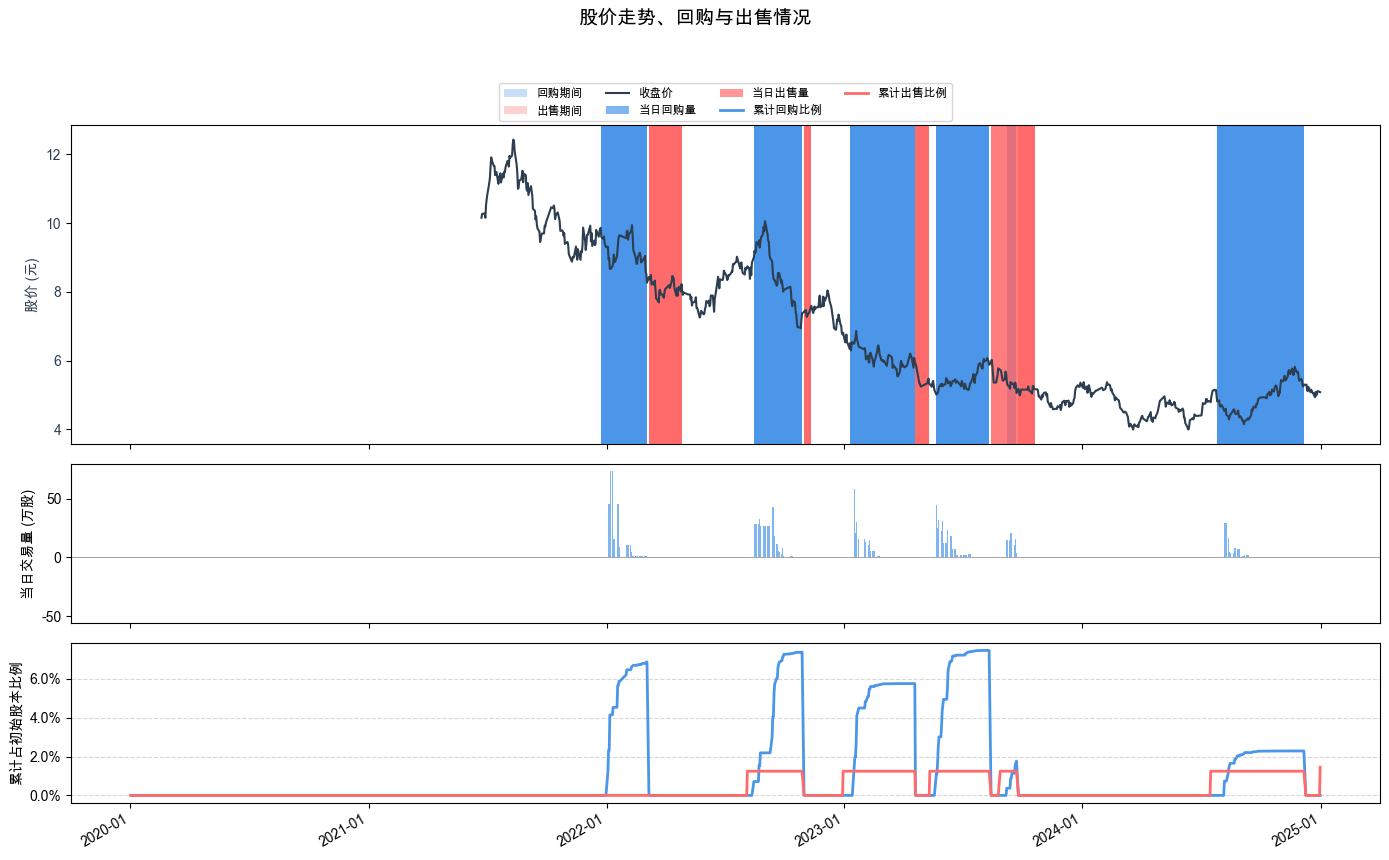

In [82]:

plot_repurchase_and_selling_timeline(one_company_df)


<Axes: >

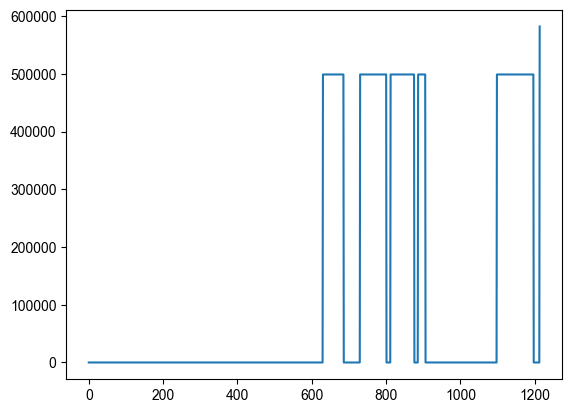

In [83]:
one_company_df['累计出售数量'].plot()

### 法律行为

In [84]:
import numpy as np
import pandas as pd

def add_legal_status(df, violation_prob=0.05):
    """
    向DataFrame添加公司法律情况列，小概率出现"重大违法行为"
    
    参数:
        df: pandas DataFrame
        violation_prob: float, 出现"重大违法行为"的概率，默认0.05 (5%)
    
    返回:
        添加了"公司法律情况"列的DataFrame
    """
    # 复制DataFrame以避免修改原始数据
    result_df = df.copy()
    
    # 生成随机布尔掩码，True的概率为violation_prob
    n_rows = len(df)
    violation_mask = np.random.random(n_rows) < violation_prob
    
    # 添加"公司法律情况"列，默认为空字符串
    result_df['公司法律情况'] = ''
    
    # 对符合掩码的行填入"重大违法行为"
    result_df.loc[violation_mask, '公司法律情况'] = '重大违法行为'
    
    return result_df

## 批量生成

In [85]:

# 财务数据
generator = FinancialDataGenerator()
financial_data = generator.generate()

# 交易数据
trading_gen = TradingDataGenerator()
trading_df = trading_gen.generate()

# 合并
combined_company_info = merge_financial_trade_data(financial_data, trading_df)
combined_company_info_copy = combined_company_info.copy()
combined_company_info_copy['日期'] = pd.to_datetime(combined_company_info_copy['日期'])

# 回购行为
one_company_df = main_simulation_repurchase(combined_company_info_copy)

# 出售回购的股份行为
one_company_df = adjust_selling_plan(simulate_share_selling(one_company_df))

# 违法行为
one_company_df = add_legal_status(one_company_df, violation_prob=0.005)


In [86]:
import random
from tqdm import tqdm

# 定义一些偏门的汉字
prefixes = ["曦", "昱", "沅", "淼", "珏", "琬", "瑾", "鸾", "翰", "裴", "霖", "钧", "铄", "骁", "颢", "麒", "筠", "珣", "芷", "蔚", "璟", "翊", "旻", "暄", "泓", "澜", "玥", "祎", "昀"]
suffixes = ["珺", "滢", "瀚", "骞", "琛", "煜", "瑄", "璨", "祺", "颉", "瀚", "霆", "翊", "琨", "璐", "璞", "琰", "璟", "琮", "琯", "瑾", "珹", "璋", "珵", "琮", "瑗", "璜", "琛", "璱", "玮"]
industries = ["股份", "科技", "实业", "集团", "控股", "电力", "化工", "物流", "医药", "地产", "机械", "农业", "传媒", "食品", "环保", "信息", "能源", "交通", "建筑", "生物"]

# First generate 50 company names using the provided code
company_names = []
for _ in range(50):
    prefix = random.choice(prefixes)
    suffix = random.choice(suffixes)
    industry = random.choice(industries)
    company_name = f"{prefix}{suffix}{industry}"
    company_names.append(company_name)

# Generate data for each company and combine
all_financial_data = []

for company in tqdm(company_names):
    # 财务数据
    generator = FinancialDataGenerator()
    financial_data = generator.generate()

    # 交易数据
    trading_gen = TradingDataGenerator()
    trading_df = trading_gen.generate()

    # 合并
    combined_company_info = merge_financial_trade_data(financial_data, trading_df)
    combined_company_info_copy = combined_company_info.copy()
    combined_company_info_copy['日期'] = pd.to_datetime(combined_company_info_copy['日期'])

    # 回购行为
    one_company_df = main_simulation_repurchase(combined_company_info_copy)

    # 出售回购的股份行为
    one_company_df = adjust_selling_plan(simulate_share_selling(one_company_df))

    # 违法行为
    one_company_df = add_legal_status(one_company_df, violation_prob=0.005)
    
    # Append to our list of all data
    one_company_df['公司简称'] = company
    all_financial_data.append(one_company_df)


# Combine all companies' data into one large DataFrame
combined_financial_data = pd.concat(all_financial_data, ignore_index=True)

# 确保所有日期列都转换为pandas的datetime格式
date_columns = ['日期', '决议通过日', '实施开始日', '实施截止日', '上市日期', '公告日期', '出售开始日', '出售截止日']

# 转换日期列
for col in date_columns:
    combined_financial_data[col] = pd.to_datetime(combined_financial_data[col])  # 对于无法解析的日期返回 NaT

combined_financial_data 

100%|██████████| 50/50 [03:14<00:00,  3.89s/it]


,日期,收盘价,总股本,公司法律情况,存在回购方案,决议通过日,实施开始日,实施截止日,回购方式,回购用途,...,出售截止日,拟出售比例,拟出售数量,当日出售价格,当日出售比例,当日出售数量,累计出售数量,累计出售比例,披露出售进展,公司简称
0,2020-01-02,NaN,4.000000e+07,,False,NaT,NaT,NaT,<NA>,<NA>,...,NaT,0.0000,0.00,0.0,0.0,0.0,0.000000,0.0000,False,旻璋科技
1,2020-01-03,NaN,4.000000e+07,,False,NaT,NaT,NaT,None,None,...,NaT,0.0000,0.00,0.0,0.0,0.0,0.000000,0.0000,False,旻璋科技
2,2020-01-06,NaN,4.000000e+07,,False,NaT,NaT,NaT,None,None,...,NaT,0.0000,0.00,0.0,0.0,0.0,0.000000,0.0000,False,旻璋科技
3,2020-01-07,NaN,4.000000e+07,,False,NaT,NaT,NaT,None,None,...,NaT,0.0000,0.00,0.0,0.0,0.0,0.000000,0.0000,False,旻璋科技
4,2020-01-08,NaN,4.000000e+07,,False,NaT,NaT,NaT,None,None,...,NaT,0.0000,0.00,0.0,0.0,0.0,0.000000,0.0000,False,旻璋科技
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60695,2024-12-25,23.793561,1.835270e+07,,False,2024-03-22,2024-04-01,2024-07-01,竞价回购,维护公司价值及股东权益所必需,...,2024-07-27,0.0596,1093090.31,0.0,0.0,0.0,0.000000,0.2076,False,筠瑄实业
60696,2024-12-26,23.131895,1.835270e+07,,False,2024-03-22,2024-04-01,2024-07-01,竞价回购,维护公司价值及股东权益所必需,...,2024-07-27,0.0596,1093090.31,0.0,0.0,0.0,0.000000,0.2076,False,筠瑄实业
60697,2024-12-27,22.848821,1.835270e+07,,False,2024-03-22,2024-04-01,2024-07-01,竞价回购,维护公司价值及股东权益所必需,...,2024-07-27,0.0596,1093090.31,0.0,0.0,0.0,0.000000,0.2076,False,筠瑄实业
60698,2024-12-30,22.598349,1.835270e+07,,False,2024-03-22,2024-04-01,2024-07-01,竞价回购,维护公司价值及股东权益所必需,...,2024-07-27,0.0596,1093090.31,0.0,0.0,0.0,0.000000,0.2076,False,筠瑄实业


In [ ]:
combined_financial_data.to_csv('data_generated/data_simulate_04.csv', index=None, encoding='utf-8-sig')

In [88]:
combined_financial_data.columns

Index(['日期', '收盘价', '总股本', '公司法律情况', '存在回购方案', '决议通过日', '实施开始日', '实施截止日',
       '回购方式', '回购用途', '回购数量上限', '回购数量下限', '资金总额上限', '资金总额下限', '要约期限', '要约价格',
       '申报价格', '当日回购数量', '累计回购数量', '已使用资金', '日收益率', '前收盘价', '上市日期', '发行价格',
       '复权因子', '净资产增长率', '净利润增长率', '净资产', '净利润', '每股净资产', '每股净利润', '公告类型',
       '公告日期', '收盘价减每股净资产', '收盘价减每股净利润', '存在出售计划', '出售开始日', '出售截止日', '拟出售比例',
       '拟出售数量', '当日出售价格', '当日出售比例', '当日出售数量', '累计出售数量', '累计出售比例', '披露出售进展',
       '公司简称'],
      dtype='object')